## 1. 라이브러리 로드

In [1]:
from flat import document, rgb, rgba, font, strike, shape
from flat.command import moveto, quadto, curveto, lineto, closepath
from bezmerizing import Polyline, Path
import numpy as np
from copy import copy

from numpy.random import uniform, normal, choice

from IPython.display import SVG, display  # Scalable Vector Graphics, SVG
def show(page):
    display(SVG(page.svg()))

## 2. 자주 사용할 함수 정의

In [2]:
def glyphcommands(f, ch):
    return Path([copy(cmd) for cmd in f.glyph(f.charmap[ord(ch)])])

def advancefor(f, ch):
    return f.advances[f.charmap[ord(ch)]]

## 3. 데이터 로드

In [3]:
f = font.open("fonts/TmoneyRoundWindExtraBold.ttf")
path_list = glyphcommands(f,"이")
cmd_list = path_list.commands

print("폰트명:", f.name)
print("Density:", f.density)

폰트명: b'TmoneyRoundWind-ExtraBold'
Density: 1000


## 4. 글리프 방향 구하기

In [4]:
def get_dir_of_glyph(cmd, pre_x, pre_y):
    
    direct = ""    
    if type(cmd) == moveto:
        direct += "start"
        return direct

    # 좌우
    if cmd.x > pre_x:
        direct += "right"
    elif cmd.x < pre_x:
        direct += "left"
    else:
        direct += ""
    
    # 상하
    if cmd.y > pre_y:
        direct += "down"
    elif cmd.y < pre_y:
        direct += "up"
    else:
        direct += ""
        
    return direct

In [5]:
def get_dir_list(path):
    dir_list = []
    
    pre_x, pre_y = -9999, -9999
    for idx, cmd in enumerate(path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
        elif type(cmd) in (lineto, quadto, curveto):
            direct = get_dir_of_glyph(cmd, pre_x, pre_y)
            dir_list.append(direct)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            dir_list.append("fin")
    
    return dir_list

In [6]:
glyph_dir = get_dir_list(path_list)
print(glyph_dir)
print(len(glyph_dir))

for i in Path(path_list).commands:  
    if hasattr(i, 'x') and hasattr(i, 'y'):
        print(type(i), ":", i.x, i.y)
    else:
        print(type(i))

['start', 'up', 'rightup', 'rightup', 'rightdown', 'rightdown', 'down', 'leftdown', 'leftdown', 'leftup', 'leftup', 'fin', 'start', 'rightdown', 'leftdown', 'leftdown', 'leftdown', 'leftdown', 'leftup', 'leftup', 'leftup', 'leftup', 'rightup', 'rightup', 'rightup', 'rightup', 'rightdown', 'rightdown', 'rightdown', 'fin', 'start', 'rightdown', 'rightup', 'rightup', 'rightup', 'rightup', 'leftup', 'leftup', 'leftup', 'leftup', 'leftdown', 'leftdown', 'leftdown', 'leftdown', 'rightdown', 'rightdown', 'rightdown', 'fin']
48
<class 'flat.command.moveto'> : 693 71
<class 'flat.command.lineto'> : 693 -709
<class 'flat.command.quadto'> : 715.5 -764.0
<class 'flat.command.quadto'> : 773 -783
<class 'flat.command.quadto'> : 831.0 -764.0
<class 'flat.command.quadto'> : 853 -709
<class 'flat.command.lineto'> : 853 71
<class 'flat.command.quadto'> : 831.0 126.0
<class 'flat.command.quadto'> : 773 145
<class 'flat.command.quadto'> : 715.5 126.0
<class 'flat.command.quadto'> : 693 71
<class 'flat.com

## 5. 글리프 분할
- 몇개짜리로 분할할 건지 받아서 자르기

In [7]:
def cut_glyph(direct, num, path):
    # c를 리스트에 어펜드
    # num = 나누는 수
    result = []
    pre_x = -9999
    for idx, cmd in enumerate(path):

        if type(cmd) == moveto:
            pre_x = cmd.x
            c = moveto(cmd.x,cmd.y)
            result.append(c)
        elif type(cmd) == lineto and direct[idx] == "right" and abs(pre_x - cmd.x) > 130:
            if abs(pre_x - cmd.x) < 200:
                short_num = num - 2
                for i in  range(1, short_num+1):
                    temp_x = pre_x + i * (cmd.x - pre_x) / short_num
                    c = lineto(temp_x, cmd.y)
                    result.append(c)
            else:                
                for i in  range(1, num+1):
                    temp_x = pre_x + i * (cmd.x - pre_x) / num
                    c = lineto(temp_x, cmd.y)
                    result.append(c)

            pre_x = cmd.x
        elif type(cmd) in (lineto, quadto, curveto):
            if type(cmd) == lineto:
                c = lineto(cmd.x, cmd.y)
                pre_x = cmd.x
            elif type(cmd) == quadto:
                c = quadto(cmd.x1, cmd.y1, cmd.x, cmd.y)
            elif type(cmd) == curveto:
                c = curveto(cmd.x1, cmd.y1, cmd.x2, cmd.y2, cmd.x, cmd.y)
            result.append(c)
        else:
            c = closepath
            result.append(c)
    return result

### 잘 잘리는지 결과 출력

In [8]:
mod_path = cut_glyph(glyph_dir, 4, path_list)
print(len(mod_path))
for i in Path(mod_path).commands:
    if hasattr(i, 'x') and hasattr(i, 'y'):
        print(type(i), ":", i.x, i.y)
    else:
        print(type(i))


48
<class 'flat.command.moveto'> : 693 71
<class 'flat.command.lineto'> : 693 -709
<class 'flat.command.quadto'> : 715.5 -764.0
<class 'flat.command.quadto'> : 773 -783
<class 'flat.command.quadto'> : 831.0 -764.0
<class 'flat.command.quadto'> : 853 -709
<class 'flat.command.lineto'> : 853 71
<class 'flat.command.quadto'> : 831.0 126.0
<class 'flat.command.quadto'> : 773 145
<class 'flat.command.quadto'> : 715.5 126.0
<class 'flat.command.quadto'> : 693 71
<class 'flat.command.closepath'>
<class 'flat.command.moveto'> : 559.0 -552.5
<class 'flat.command.quadto'> : 575 -417
<class 'flat.command.quadto'> : 559.0 -281.5
<class 'flat.command.quadto'> : 511.0 -178.0
<class 'flat.command.quadto'> : 429.5 -111.5
<class 'flat.command.quadto'> : 314 -88
<class 'flat.command.quadto'> : 198.5 -111.5
<class 'flat.command.quadto'> : 117.0 -178.0
<class 'flat.command.quadto'> : 69.0 -281.5
<class 'flat.command.quadto'> : 53 -417
<class 'flat.command.quadto'> : 69.0 -552.5
<class 'flat.command.quadto

In [9]:
def mod_cloud_corrdinate_value(direct, mid_x, mid_y, av, cmd):
    
    c = copy(cmd)
    if direct.count('+')==2:  # 대각선
        if "right+up" in direct:
            c = quadto(x1=mid_x-av, y1=mid_y-av, x=cmd.x, y=cmd.y)
        elif "right+down" in direct:
            c = quadto(x1=mid_x+av, y1=mid_y-av, x=cmd.x, y=cmd.y)
        elif "left+up" in direct:
            c = quadto(x1=mid_x-av, y1=mid_y+av, x=cmd.x, y=cmd.y)
        elif "left+down" in direct:
            c = quadto(x1=mid_x+av, y1=mid_y+av, x=cmd.x, y=cmd.y)
        
    else:  # 상하좌우
        if "right" in direct:
            c = quadto(x1=mid_x, y1=mid_y-av, x=cmd.x, y=cmd.y)
        elif "left" in direct:
            c = quadto(x1=mid_x, y1=mid_y+av, x=cmd.x, y=cmd.y)
        elif "up" in direct:
            c = quadto(x1=mid_x-av, y1=mid_y, x=cmd.x, y=cmd.y)
        elif "down" in direct:
            c = quadto(x1=mid_x+av, y1=mid_y, x=cmd.x, y=cmd.y)
    
    return c

In [10]:
def change_glyph_to_quad(cmd, direct, av, pre_x, pre_y):
    c = copy(cmd)
    if type(cmd) == moveto:
        c = moveto(cmd.x, cmd.y)
    elif type(cmd) in (lineto, quadto, curveto):
        if direct == 'right' or direct == "rightup" or direct == "rightdown":
            if type(cmd) is not curveto and abs(pre_x - cmd.x) > 90:    #95
                mid_x = (cmd.x + pre_x) / 2
                mid_y = (cmd.y + pre_y) / 2
                
                #디자인 적용
                c = mod_cloud_corrdinate_value(direct, mid_x, mid_y, av, cmd)
    else:
        c = closepath

    return c

In [11]:
def make_design_glyph(input_path, glyph_dir, av):
    pre_x = 0
    pre_y = 0

    design_glyph_list = []
    for idx, cmd in enumerate(input_path):
        if type(cmd) == moveto:
            pre_x = cmd.x
            pre_y = cmd.y
            c = change_glyph_to_quad(cmd, glyph_dir[idx], av, pre_x, pre_y)
        elif type(cmd) in (lineto, quadto, curveto):
            c = change_glyph_to_quad(cmd, glyph_dir[idx], av, pre_x, pre_y)
            pre_x = cmd.x
            pre_y = cmd.y
        else:
            c = closepath
            pre_x = 0
            pre_y = 0

        design_glyph_list.append(c)
        
    return design_glyph_list

In [12]:
from itertools import chain
def combine_path(f, s):
    text_paths = []
    cx = 0
    for ch in s:
        glyph_path = glyphcommands(f, ch).translate(cx, 0)
        glyph_dir = get_dir_list(glyph_path)

        mod_path = cut_glyph(glyph_dir,4,glyph_path)

        text_paths.append(Path(mod_path))
        cx += advancefor(f, ch)
    combined = Path(list(chain(*text_paths)))
    return combined

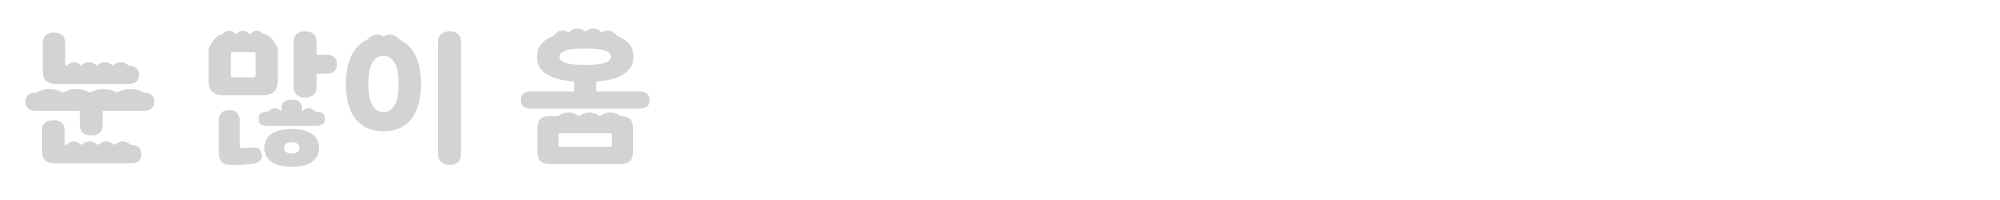

In [13]:
mod_path = combine_path(f, "눈 많이 옴")
av = 50

glyph_path_direct = get_dir_list(mod_path)
#print("글리프들의 방향:", glyph_path_direct)

mod_glyph = make_design_glyph(mod_path, glyph_path_direct, av)
mod_path = Path(mod_glyph)

page = document(2000, 200, 'pt').addpage()
pen = shape().nostroke().fill(rgb(211, 211, 211))
page.place(pen.path(mod_path.scale(144/f.density).translate(20, 144)))
show(page)

## 6. 눈사람 그리기

In [14]:
"""
snowman = [moveto(680,5),
            quadto(615,-36,680,-79),
            quadto(645,-105.5,680,-133),
            quadto(695,-145,710,-133),
            quadto(745,-105.5,710,-79),
            quadto(775,-36,710,5),
            closepath]
"""

snowman = [moveto(780,15),
            quadto(715,-26,780,-69),
            quadto(745,-95.5,780,-123),
            quadto(795,-135,810,-123),
            quadto(845,-95.5,810,-69),
            quadto(875,-26,810,15),
            closepath]

snowman_path = Path(snowman)



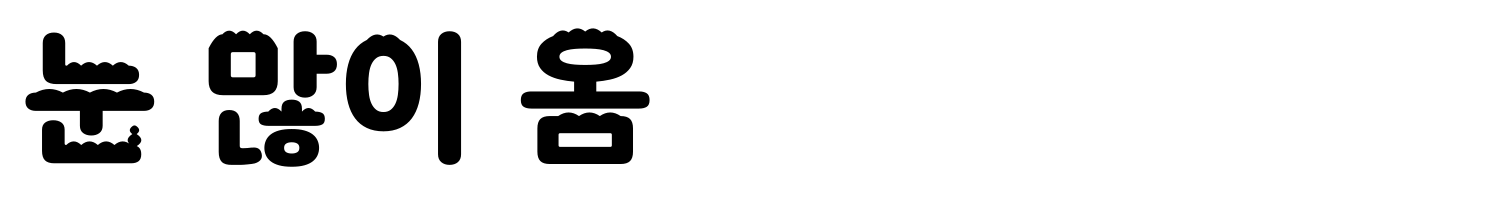

In [15]:
av = 50 # 최적 50

#glyph_path_direct = get_dir_list(mod_path)
#print("글리프들의 방향:", glyph_path_direct)

mod_glyph = make_design_glyph(mod_path, glyph_path_direct, av)
mod_path = Path(mod_glyph) + snowman_path

page = document(1500, 200, 'pt').addpage()
pen = shape().nostroke().fill(rgb(0, 0, 0))
page.place(pen.path(mod_path.scale(144/f.density).translate(20, 144)))

show(page)